In [27]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import util

# Prepare data for analysis

Here we load the data sets used, and count the number of mutations that occur over all genes available in the RNA sequencing datasets. The data are further transformed to provide mutations per kilobase over all genes

In [8]:
somatic_mutation_columns = ('submitted_sample_id', 'submitted_matched_sample_id', 'chromosome',
                            'chromosome_start', 'chromosome_end', 'chromosome_strand',
                            'mutation_type', 'gene_affected')

# Somatic mutation file available from https://dcc.icgc.org/releases/current/Projects/BRCA-EU
# All other data sets available at https://cimprichlab.github.io/
mutations = pd.read_csv('simple_somatic_mutation.open.BRCA-EU.tsv', sep='\t', usecols=somatic_mutation_columns)
match_data = pd.read_hdf('normalization_data.hdf')
RNA_seq = pd.read_hdf('RNA_z_score_updated.hdf', 'RNA')

In [9]:
# Inner join on RNA-seq data set to restrict to only genes with expression information
# Also allows us to use gene symbols in analysis
mutations = mutations.merge(RNA_seq[['gene_name', 'gene_id']], left_on='gene_affected', right_on='gene_id')

# Bed file of gene coordinates for all UCSC genes
gene_boundaries = pd.read_csv('ucsc_genes.bed', sep='\t', header=None, names=('chr', 'start', 'end', 'gene_name'))
gene_boundaries['length'] = gene_boundaries.end - gene_boundaries.start

# Count up mutations over genes and merge with gene length data
mutations_per_gene = mutations.groupby('gene_name').size()
mutations_per_gene = gene_boundaries.merge(pd.DataFrame(mutations_per_gene), right_index=True, left_on='gene_name')
mutations_per_gene.columns = ('chr', 'start', 'end', 'gene_name', 'length', 'mutation_count')

# Calculate mutations per kilobase over each gene
mutations_per_gene['mutation_density'] = mutations_per_gene.mutation_count / mutations_per_gene.length
mutations_per_gene.mutation_density *= 1000

# Generate matched set for genes induced at 21 hours in data set

In order to compare mutation frequencies that we observe in estrogen-induced genes, we match the genes in our induced set to the closest possible genes not in the induced set for replication timing and mean expression

In [29]:
induced_21_genes = set(RNA_seq[RNA_seq['24hr_induced']].gene_name)

induced_set, matched_set = util.matched_pairs_multiple_factors(match_data, 
                                   induced_21_genes, ['rep_timing', 'mean_expression'], col_weights = [1,1],
                                   distance_cutoff = 0.5, studentize_cols=True)

# Check quality of match

Here we create joint plots to show the distributions of replication timing and mean expression in our matched set versus our set of induced genes.

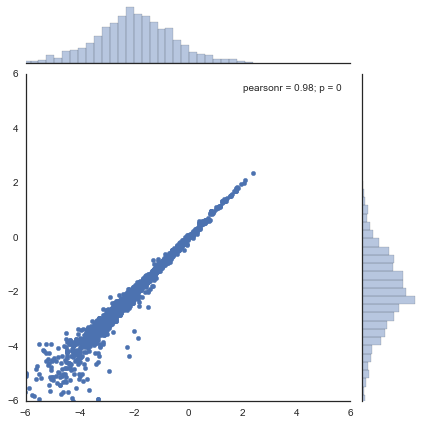

In [34]:
sns.set_style('white')
fig = sns.jointplot(np.log(induced_set.mean_expression.as_matrix()), 
                    np.log(matched_set.mean_expression.as_matrix()),xlim=(-6,6),ylim=(-6,6))
plt.savefig('muts_expr_match_2.svg')

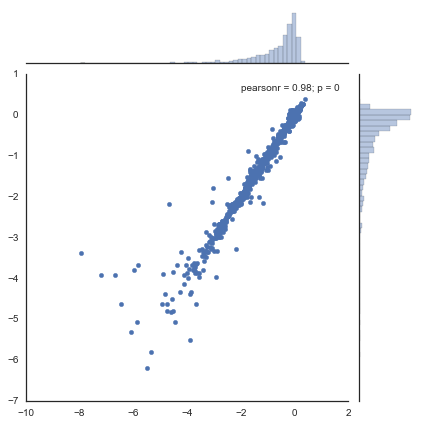

In [33]:
sns.set_style('white')
fig = sns.jointplot(np.log(induced_set.rep_timing.as_matrix()), 
                    np.log(matched_set.rep_timing.as_matrix()))
plt.savefig('muts_repl_match_2.svg')

# Density of mutations

We plot here the density of mutations (as mutations/kb) in the estrogen induced genes versus the matched set

In [38]:
def overlay_plot_mutations_normalized_to_gene_log(gene_set, matched_gene_set, title="Comparison with matched set", sample_names=None):
    plt.figure(figsize=(6,4.5))
    sns.set_style('white')
    ax = (pd.Series(np.log(mutations_per_gene[mutations_per_gene.gene_name.isin(gene_set)].mutation_density))
          .hist(bins=np.arange(-7,7,0.5), color='#FF3333', alpha=0.5,normed=True))
    ax2 = (pd.Series(np.log(mutations_per_gene[mutations_per_gene.gene_name.isin(matched_gene_set)].mutation_density))
           .hist(bins=np.arange(-7,7,0.5), color='#3333FF', alpha=0.5,normed=True))
    ax.set_title(title)
    ax.grid(False)
    ax.set_xlabel('Log mutations per kilobase')
    if not sample_names:
        sample_names = ['Test set', 'Matched set']
    ax.legend(sample_names)
    sns.set(font_scale=1.0)

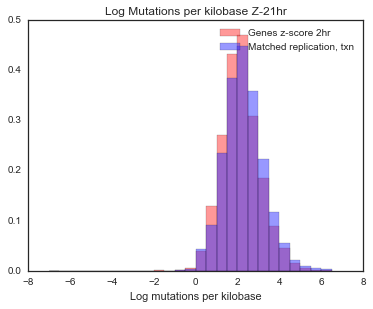

In [39]:
sns.set_style('white')
overlay_plot_mutations_normalized_to_gene_log(induced_set.gene_name, matched_set.gene_name , 
                                          title="Log Mutations per kilobase Z-21hr", 
                                          sample_names=['Genes z-score 2hr', 'Matched replication, txn'])
#plt.savefig('Z-24hr-muts-2.svg')

# Determine statistical significance for difference

Using a 2-tailed bootstrap of the median, we will determine whether the two gene sets show significant differences in mutation density. Note that this function is not optimized for memory use.

In [46]:
median_differences = util.bootstrap_test_2_samples_median_2_tailed(np.log(mutations_per_gene.mutation_density),
                                    np.log(mutations_per_gene[mutations_per_gene.gene_name.isin(matched_set.gene_name)].mutation_density),
                                    np.log(mutations_per_gene[mutations_per_gene.gene_name.isin(induced_set.gene_name)].mutation_density),
                                    1000000
                                   )

In [47]:
print("Probability of difference: p < {}".format(util.pvalue_ceiling(median_differences)))

Probability of difference: p < 0.0001
